# Propagation Relation
S. Jones 09/07/24

Notebook designed to look at if we can extract an analytical form that can be used to quickly calculate retarded times.

In [2]:
# Some standard imports
import src.QTNMTraps as traps
import src.Particle as part
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy.optimize import curve_fit

In [3]:
# Use Latex in figure text
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Make labels bigger
plt.rcParams.update({'font.size': 12})

## Harmonic trap
Initially look at the propagation time in a harmonic trap. We are interested in the relationship between the emission time, $t_{\text{emit}}$, and reception time, $t_{\text{receive}}$.

In [4]:
# Define a harmonic trap
B0 = 1.0  # T
L0 = 0.2  # m
# Define trap
harmonicTrap = traps.HarmonicTrap(B0, L0)

In [5]:
# Define a receiver position
zR = -0.05  # metres
receiverPosition = np.array([0.0, 0.0, zR])
pitchAngleInit = 87.0 * np.pi / 180.0

# Define electron
eKE = 18.575e3  # eV
startPos = np.array([1e-5, 0.0, 0.0])
electron = part.Particle(eKE, np.array([1e-5, 0.0, 0.0]),
                         pitchAngle=pitchAngleInit)

In [6]:
# Get the electron position as a function of time
tObs = 0.1e-6  # seconds
samplePeriod = 5e-10  # seconds
timeArray = np.arange(0, tObs, samplePeriod)
electronZPos = harmonicTrap.GetZPosTime(timeArray, electron.GetSpeed(),
                                        pitchAngleInit)
# For each point, calculate the signal arrival time
arrivalTimes = timeArray + abs(zR - electronZPos) / sc.c

# Define a shifted sine wave to fit to the above relationship
def ShiftedSine(x, A, omega, phi, yOffset):
    return A * np.sin(omega * x + phi) + yOffset

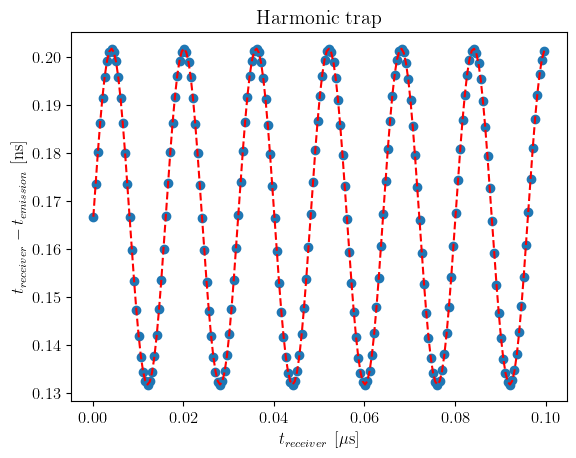

In [7]:
plt.figure()
plt.plot(arrivalTimes * 1e6, (arrivalTimes - timeArray) * 1e9, 'o')
plt.title("Harmonic trap")
plt.xlabel("$t_{receiver}$ [$\mu$s]")
plt.ylabel("$t_{receiver} - t_{emission}$ [ns]")

# Now fit the sine wave to the data
popt, pcov = curve_fit(ShiftedSine, arrivalTimes, arrivalTimes - timeArray,
                       p0=[0.01e-9, 2 * np.pi * 60e6, 0.0, 0.165e-9])
# Draw the fit
fitTimes = ShiftedSine(arrivalTimes, *popt)
plt.plot(arrivalTimes * 1e6, fitTimes * 1e9, 'r--')
plt.show()

We can actually try and compare some of the fit parameters with our guesses from where they come from.

In [8]:
# Compare parameters with calculated values
omega_a = harmonicTrap.CalcOmegaAxial(pitchAngleInit, electron.GetSpeed())
print(f"Calculated Omega_a vs. omega fit value: {omega_a:.3e} vs. {popt[1]:.3e}")
offsetCalc = abs(zR) / sc.c
print(f"Calculated offset vs. yOffset fit value: {offsetCalc:.3e} vs. {popt[3]:.3e}")
amplitudeCalc = harmonicTrap.CalcZMax(pitchAngleInit) / sc.c
print(
    f"Calculated amplitude vs. amplitude fit value: {amplitudeCalc:.3e} vs. {popt[0]:.3e}")

Calculated Omega_a vs. omega fit value: 3.930e+08 vs. 3.930e+08
Calculated offset vs. yOffset fit value: 1.668e-10 vs. 1.668e-10
Calculated amplitude vs. amplitude fit value: 3.496e-11 vs. 3.496e-11


### Moving the receiver point
Now, look at what happens if we move the receiver point in an arc.

In [13]:
receiverAngles = np.linspace(0, np.pi / 2, 6)
electronPosTime = np.array([np.zeros_like(electronZPos), 
                            np.zeros_like(electronZPos), electronZPos])

plt.figure()
for ang in receiverAngles:
  rAngPosition = zR * np.array([np.sin(ang), 0.0, np.cos(ang)])
  aTimesAng = np.zeros_like(timeArray)
  for it, t in enumerate(timeArray):
    electronPos = np.array([0, 0, harmonicTrap.GetZPosTime(t, electron.GetSpeed(), pitchAngleInit)])
    aTimesAng[it] = t + np.linalg.norm(rAngPosition - electronPos) / sc.c

  plt.plot(aTimesAng * 1e6, (aTimesAng - timeArray) * 1e9, 'o')

plt.show()

## Bathtub trap
Now look at generating a bathtub trap.

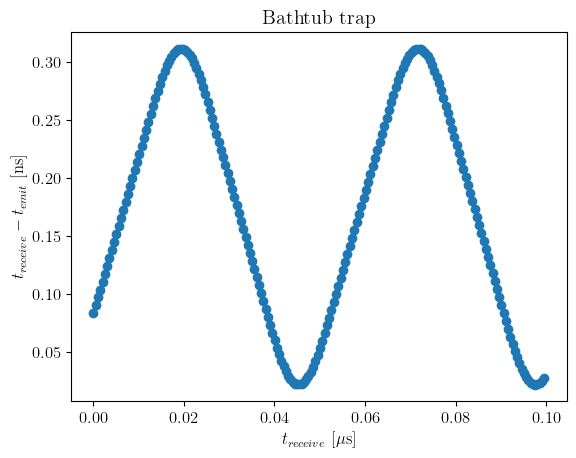

In [10]:
# Define trap
L0_bt = 0.35    # m
L1_bt = 5e-2  # m
B0_bt = 1.0     # T
bathtubTrap = traps.BathtubTrap(B0_bt, L0_bt, L1_bt)
electronZPos_bt = bathtubTrap.GetZPosTime(timeArray, electron.GetSpeed(),
                                          pitchAngleInit)
# For each point, calculate the signal arrival time
arrivalTimes_bt = timeArray + abs(zR - electronZPos_bt) / sc.c
plt.figure()
plt.plot(arrivalTimes_bt * 1e6, (arrivalTimes_bt - timeArray) * 1e9, 'o')
plt.title("Bathtub trap")
plt.xlabel("$t_{receive}$ [$\mu$s]")
plt.ylabel("$t_{receive} - t_{emit}$ [ns]")
plt.show()